In [87]:
# LOAD THE ENV CONTENT
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

In [88]:
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, List
from model import create_gemini_model
from IPython.display import display, Markdown, Image
from langgraph.graph import StateGraph, START, END
import json
from knowledge_base import search_vector_db

In [89]:
# INITIALIZING MEMORY AND AGENT STATE
memory = MemorySaver()

class ProblemDetails(TypedDict):
    user_question: str
    problem_type: str

class KbSearchResults(TypedDict):
    Score: float
    Subject: str
    Problem: str
    Solution: str
    Level: str
    Type: str

class AgentState(TypedDict):
    problem_details: ProblemDetails
    kb_search_results: KbSearchResults
    final_solution: str


In [90]:
# CREATING THE MODEL
model = create_gemini_model(model_name="gemini-2.5-pro", temperature=0.1)
# response = model.invoke("How to find the area of a circle?")
# # Convert to string and display
# content = "\n\n".join(response.content) if isinstance(response.content, list) else str(response.content)
# display(Markdown(content))

✅ Successfully created Gemini model: gemini-2.5-pro
   Temperature: 0.1
   Max tokens: Not set
   Top-p: 0.8
   Top-k: 40


In [91]:
# ALL AGENT SYSTEM PROMPTS

PROBLEM_TYPE_FINDER_PROMPT = """ 
You are a math domain expert and problem type classifier. Given a math problem, you must return the most suitable category from the following:

["algebra", "counting and probability", "geometry", "intermediate_algebra", "number_theory", "prealgebra", "precalculus"]

Here are some examples:

---

**Problem:** What is the value of 2x + 3 when x = 4?  
**Category:** algebra

**Problem:** How many different ways can 3 books be arranged on a shelf?  
**Category:** counting and probability

**Problem:** Find the area of a triangle with base 10 and height 5.  
**Category:** geometry

**Problem:** Solve the inequality: 3x - 5 > 10  
**Category:** intermediate_algebra

**Problem:** What is the greatest common divisor of 24 and 36?  
**Category:** number_theory

**Problem:** Simplify: 5 + 3 × 2  
**Category:** prealgebra

**Problem:** What is the derivative of x²?  
**Category:** precalculus

---

Now classify the following problem accordingly. Return only the category name.
**Problem:** {problem}
**Category:** 
"""

SOLUTION_GENERATOR_PROMPT = """ 
You are a professional math tutor.

Problem Type: {problem_type}
User's Question: {user_question}

Here are some similar solved examples from the knowledge base:
{examples_text}

Now, using the above context, write a clear and step-by-step professional solution to the user's question.
Start the solution with "Solution:" and be thorough.
    """


In [92]:
# CREATING THE AGENT

class Agent:
    def __init__(self, model,user_query):
        self.model = model
        graph = StateGraph(AgentState)

        def user_input(state: AgentState) -> AgentState:
            state["problem_details"]["user_question"] = user_query
            print(f"User input: {state['problem_details']['user_question']}")
            return state

        def find_problem_type(state: AgentState) -> AgentState:
            problem_type_finder_prompt = PROBLEM_TYPE_FINDER_PROMPT.format(problem=state["problem_details"]["user_question"])
            response = self.model.invoke(problem_type_finder_prompt)
            print(f"Problem type: {response.content}")
            state["problem_details"]["problem_type"] = response.content
            return state

        def kb_retriever(state: AgentState) -> AgentState:
            raw_results = search_vector_db(
                query = state["problem_details"]["user_question"] + " " + state["problem_details"]["problem_type"],
                top_k = 5
            )
            print(f"No of similar problems found: {len(raw_results)}")

            # Store only clean JSON-safe dictionaries
            cleaned_results = []
            for r in raw_results:
                try:
                    cleaned_results.append({
                        "Score": float(r.score),
                        "Subject": r.payload.get("subject", ""),
                        "Problem": r.payload.get("problem", ""),
                        "Solution": r.payload.get("solution", ""),
                        "Level": r.payload.get("level", ""),
                        "Type": r.payload.get("type", "")
                    })
                except Exception as e:
                    print(f"Error cleaning result: {e}")

            state["kb_search_results"] = cleaned_results  # ONLY this, not raw_results
            return state

        def solution_generator(state: AgentState) -> AgentState:
            user_question = state["problem_details"]["user_question"]
            problem_type = state["problem_details"]["problem_type"]
            kb_results = state["kb_search_results"]
            examples_text = "\n".join([f"Problem: {r['Problem']}\nSolution: {r['Solution']}" for r in kb_results])
            solution_generator_prompt = SOLUTION_GENERATOR_PROMPT.format(user_question=user_question, problem_type=problem_type, examples_text=examples_text)
            response = self.model.invoke(solution_generator_prompt)
            # print(f"Solution: {response.content}")
            state["final_solution"] = response.content
            return state

        graph.add_node("user_input_node", user_input)
        graph.add_node("problem_type_finder_node", find_problem_type)
        graph.add_edge(START, "user_input_node")
        graph.add_edge("user_input_node", "problem_type_finder_node")
        graph.add_node("kb_retriever_node", kb_retriever)
        graph.add_edge("problem_type_finder_node", "kb_retriever_node")
        graph.add_node("solution_generator_node", solution_generator)
        graph.add_edge("kb_retriever_node", "solution_generator_node")
        graph.add_edge("solution_generator_node", END)


        self.graph = graph.compile(checkpointer=memory)


        

In [95]:
user_query = "Find the area of a triangle with base 10 and height 5"
Math_Tutor = Agent(model, user_query)


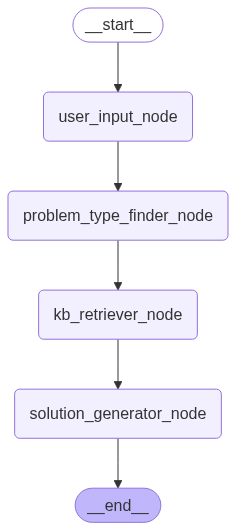

In [96]:
Image(Math_Tutor.graph.get_graph().draw_mermaid_png())

In [97]:
intial_state = {
    "problem_details": {
        "user_question": "",
        "problem_type": ""
    },
    "kb_search_results": {
        "Score": 0.0,
        "Subject": "",
        "Problem": "",
        "Level": "",
        "Type": ""
    },
    "final_solution": ""
}

final_state = list(Math_Tutor.graph.stream(
    intial_state,
    config={"thread_id": "1"},
    stream_mode="values"
))


# for state in final_state:
#     print(json.dumps(state, indent=2))
#     print("\n")
#     print("="*50)

final_answer = final_state[-1]["final_solution"]
display(Markdown(final_answer))

User input: Find the area of a triangle with base 10 and height 5


c:\Users\91889\OneDrive\Documents\Personal Projects\AI Planet\Math_Tutor\venv\Lib\site-packages\langchain_google_genai\chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Problem type: geometry


c:\Users\91889\OneDrive\Documents\Personal Projects\AI Planet\Math_Tutor\venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\91889\OneDrive\Documents\Personal Projects\AI Planet\Math_Tutor\venv\Lib\site-packages\langchain_google_genai\chat_models.py:357: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


No of similar problems found: 5


Solution:
Of course! Let's find the area of the triangle step-by-step.

**1. Recall the Formula**

The formula for the area of a triangle is:
Area = (1/2) × base × height

This formula is fundamental for solving this type of problem.

**2. Identify the Given Values**

From the problem statement, we are given:
*   base (b) = 10
*   height (h) = 5

**3. Substitute the Values into the Formula**

Now, we plug the given values for the base and height into the area formula:
Area = (1/2) × 10 × 5

**4. Calculate the Area**

We can perform the multiplication in any order. Let's multiply the base and height first:
10 × 5 = 50

Now, we multiply this result by 1/2 (which is the same as dividing by 2):
Area = (1/2) × 50
Area = 25

**Conclusion**

The area of a triangle with a base of 10 and a height of 5 is **25 square units**.